# Create a feature engineering pipeline

In Section 1, you tabularized a sales time series dataset to forecast sales for the next week.

In this assignment, your task is to line up those feature engineering steps within a pipeline to directly obtain the features from the input data and then forecast sales using Lasso.

The most straightforward method is probably to use the open-source library Feature-engine. But you are welcome to use other libraries, code your transformers manually, or, why not, code our own pipeline?

To prepare the dataset for this assignment, please follow the guidelines in the notebook `02-create-online-retail-II-datasets.ipynb` in the `01-Create-Datasets` folder.

In [1]:
# imports
import pandas as pd

In [3]:
# load weekly sales dataset

# Adjust the following function based on where 
# you stored the dataset
filename = "../../Datasets/online_retail_dataset.csv"

df = pd.read_csv(
    filename,
    usecols=["week", "United Kingdom"],
    parse_dates=["week"],
    index_col=["week"],
)

df.columns = ['sales']

df.head()

,sales
week,
2009-12-06,213000.35
2009-12-13,195810.04
2009-12-20,182396.74
2009-12-27,22007.77
2010-01-03,0.00


## Plot time series

<Axes: xlabel='week'>

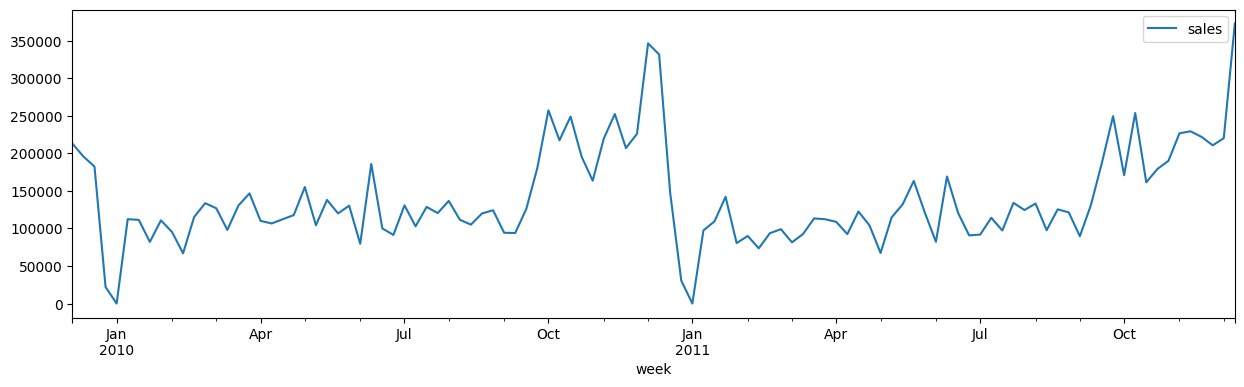

In [4]:
df.plot(figsize=[15, 4])

Check whether we have missing weeks:

In [17]:
df.reset_index()["week"].diff().dropna().value_counts()

7 days    105
Name: week, dtype: int64

No missing weeks in the data.

## Feature engineering

These are the feature engineering steps that you need to fit into a pipeline:

- Datetime features: Create the feature **month** from the timestamp.
- Cyclical features: transform the month with the sine and cosine functions.
- Lag features: Create the feature lag-1 by lagging 1 week of data.
- Window features: take the min, max and average sales values in the past 2 and 4 weeks of data.
- Drop missing data.

First set up suitable transformers / transformations and make sure they work.

In [8]:
# Create the feature month from the timestamp.
from feature_engine.datetime import DatetimeFeatures

dtf = DatetimeFeatures("index", features_to_extract=["year", "quarter", "month", "week"])
dtf.fit_transform(df)

,sales,year,quarter,month,week
week,,,,,
2009-12-06,213000.35,2009,4,12,49
2009-12-13,195810.04,2009,4,12,50
2009-12-20,182396.74,2009,4,12,51
2009-12-27,22007.77,2009,4,12,52
2010-01-03,0.00,2010,1,1,53
...,...,...,...,...,...
2011-11-13,229378.01,2011,4,11,45
2011-11-20,221870.29,2011,4,11,46
2011-11-27,210741.76,2011,4,11,47


In [11]:
# Transform the month with the sine and cosine functions
from feature_engine.creation import CyclicalFeatures

ccf = CyclicalFeatures(["quarter", "month", "week"], drop_original=False)
ccf.fit_transform(dtf.fit_transform(df))

,sales,year,quarter,month,week,quarter_sin,quarter_cos,month_sin,month_cos,week_sin,week_cos
week,,,,,,,,,,,
2009-12-06,213000.35,2009,4,12,49,-2.449294e-16,1.000000e+00,-2.449294e-16,1.000000,-4.566292e-01,0.889657
2009-12-13,195810.04,2009,4,12,50,-2.449294e-16,1.000000e+00,-2.449294e-16,1.000000,-3.482016e-01,0.937420
2009-12-20,182396.74,2009,4,12,51,-2.449294e-16,1.000000e+00,-2.449294e-16,1.000000,-2.348860e-01,0.972023
2009-12-27,22007.77,2009,4,12,52,-2.449294e-16,1.000000e+00,-2.449294e-16,1.000000,-1.182732e-01,0.992981
2010-01-03,0.00,2010,1,1,53,1.000000e+00,6.123234e-17,5.000000e-01,0.866025,-2.449294e-16,1.000000
...,...,...,...,...,...,...,...,...,...,...,...
2011-11-13,229378.01,2011,4,11,45,-2.449294e-16,1.000000e+00,-5.000000e-01,0.866025,-8.124869e-01,0.582979
2011-11-20,221870.29,2011,4,11,46,-2.449294e-16,1.000000e+00,-5.000000e-01,0.866025,-7.378333e-01,0.674983
2011-11-27,210741.76,2011,4,11,47,-2.449294e-16,1.000000e+00,-5.000000e-01,0.866025,-6.528221e-01,0.757511


In [10]:
# Create the feature lag-1 by lagging 1 week of data.
from feature_engine.timeseries.forecasting import LagFeatures

lagf = LagFeatures("sales", periods=1)
lagf.fit_transform(df)

,sales,sales_lag_1
week,,
2009-12-06,213000.35,NaN
2009-12-13,195810.04,213000.35
2009-12-20,182396.74,195810.04
2009-12-27,22007.77,182396.74
2010-01-03,0.00,22007.77
...,...,...
2011-11-13,229378.01,226770.53
2011-11-20,221870.29,229378.01
2011-11-27,210741.76,221870.29


In [18]:
# Here we take the average, maximum, and minimum values
# of the previous 2 and 4 weeks.
from feature_engine.timeseries.forecasting import WindowFeatures

wf = WindowFeatures("sales", window=[2, 4])
wf.fit_transform(df)

,sales,sales_window_2_mean,sales_window_4_mean
week,,,
2009-12-06,213000.35,NaN,NaN
2009-12-13,195810.04,NaN,NaN
2009-12-20,182396.74,204405.195,NaN
2009-12-27,22007.77,189103.390,NaN
2010-01-03,0.00,102202.255,153303.7250
...,...,...,...
2011-11-13,229378.01,208402.365,189337.3350
2011-11-20,221870.29,228074.270,206322.2025
2011-11-27,210741.76,225624.150,217013.2575


In [20]:
# Drop missing data.
from feature_engine.imputation import DropMissingData

dna = DropMissingData()
dna.fit_transform(wf.fit_transform(df))

,sales,sales_window_2_mean,sales_window_4_mean
week,,,
2010-01-03,0.000,102202.2550,153303.72500
2010-01-10,112318.850,11003.8850,100053.63750
2010-01-17,111460.470,56159.4250,79180.84000
2010-01-24,82065.331,111889.6600,61446.77250
2010-01-31,110790.591,96762.9005,76461.16275
...,...,...,...
2011-11-13,229378.010,208402.3650,189337.33500
2011-11-20,221870.290,228074.2700,206322.20250
2011-11-27,210741.760,225624.1500,217013.25750


In [21]:
# Drop original time series
from feature_engine.selection import DropFeatures

drf = DropFeatures("sales")
drf.fit_transform(wf.fit_transform(df))

,sales_window_2_mean,sales_window_4_mean
week,,
2009-12-06,NaN,NaN
2009-12-13,NaN,NaN
2009-12-20,204405.195,NaN
2009-12-27,189103.390,NaN
2010-01-03,102202.255,153303.7250
...,...,...
2011-11-13,208402.365,189337.3350
2011-11-20,228074.270,206322.2025
2011-11-27,225624.150,217013.2575


## ML Workflow

- Load the data again.
- Split the data into a suitable train and test set.
- Align all feature engineering steps in a pipeline.
- Create the features.
- Train a model.
- Evaluate the model.

In [24]:
df.index.min(), df.index.max()

(Timestamp('2009-12-06 00:00:00'), Timestamp('2011-12-11 00:00:00'))

In [40]:
# The offset for the test set
split_date = "2011-01-01"

In [41]:
# Split the data in time.
df_train = df[df.index < split_date]
df_test = df[df.index >= (pd.to_datetime(split_date) - pd.offsets.Week(4))]

In [50]:
# Target (in this dataset, is is the train set itself)

# I handle that differently later
# y_train = df_train.copy()
# y_test = df_test.copy()

Apply the feature pre-processing as pipeline

In [73]:
from sklearn.pipeline import Pipeline

feature_pipe = Pipeline([
    ("datetime", dtf),
    ("cyclic", ccf),
    ("lag", lagf),
    ("window", wf),
    ("dropna", dna),
    # ("dropfeature", drf) <- this should drop the "sales" feature, but we extract it manually
])

X_train = feature_pipe.fit_transform(df_train)
X_test = feature_pipe.transform(df_test)

# Make sure that features and targets are aligned and have the same number of data points
y_train = X_train[["sales"]].copy()
X_train = DropFeatures("sales").fit_transform(X_train)
y_test = X_test[["sales"]].copy()
X_test = DropFeatures("sales").fit_transform(X_test)

assert X_train.index.max() < X_test.index.min()
print("Difference between last training and first test point:", abs(X_train.index.max() - X_test.index.min()))

assert len(set(X_train.columns) & set(y_train.columns)) == 0
assert len(set(X_test.columns) & set(y_test.columns)) == 0

Difference between last training and first test point: 7 days 00:00:00


## Machine Learning

In [76]:
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error

linear_model = Lasso(alpha=100, random_state=0)

linear_model.fit(X_train, y_train)

# Performance of linear model
print("train rmse: ", mean_squared_error(
    y_train, linear_model.predict(X_train), squared=False,))

print("test rmse: ",  mean_squared_error(
    y_test, linear_model.predict(X_test), squared=False,))

train rmse:  33895.53875330915
test rmse:  40404.98774435707


Plot time series predictons

Text(0.5, 1.0, 'Test set')

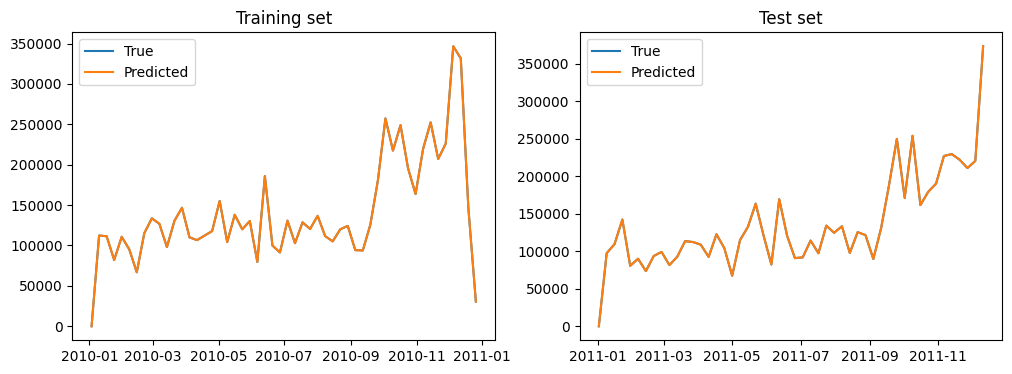

In [72]:
import matplotlib.pyplot as plt

fig, axrr = plt.subplots(1, 2, figsize=(12, 4))

axrr[0].plot(y_train, label="True")
axrr[0].plot(pd.DataFrame(linear_model.predict(X_train), index=X_train.index, columns=["sales"]), label="Predicted")
axrr[0].legend()
axrr[0].set_title("Training set")

axrr[1].plot(y_test, label="True")
axrr[1].plot(pd.DataFrame(linear_model.predict(X_test), index=X_test.index, columns=["sales"]), label="Predicted")
axrr[1].legend()
axrr[1].set_title("Test set")

Inspect model coefficients

<Axes: >

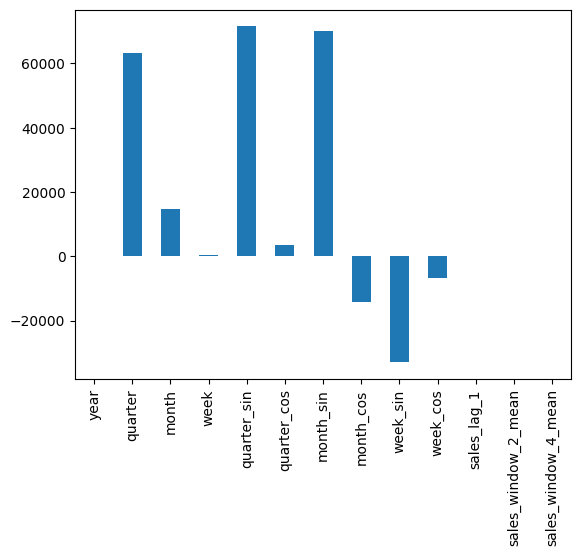

In [80]:
ax = pd.DataFrame(linear_model.coef_, index=X_train.columns).plot(kind="bar", legend=False)

Interestingly the actual sales (lags and windows) do not matter for the prediction.